In [7]:
import numpy as np
import matplotlib.pylab as plt
import math
import pandas as pd
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

In [8]:
class RLS_Filter:
    def __init__(self, num_vars, lam, delta):
        '''
        num_vars: Degree of polinomial
        lam: Forgetting factor, usually very close to 1
        delta: Initation value -> ! Bad initation needs more itteration to reach same accuracy
        '''
        self.num_vars = num_vars
        self.P = delta*np.matrix(np.identity(self.num_vars))

        # Weigths/Coefficent of the system
        self.w = np.matrix(np.zeros(self.num_vars))
        self.w = self.w.reshape(self.w.shape[1],1)

        # Kalman Gain Factor
        self.g = np.matrix(np.zeros(num_vars))
        self.g = np.reshape(self.g,(num_vars,1))
        
        # Variables needed for add_obs
        self.lam_inv = lam**(-1)
        
        # A priori error
        self.a_priori_error = 0
        
        # Count of number of observations added
        self.num_obs = 0

    def add_obs(self, x, t):
        '''
        Expected value is t, add the new observation as t.
        t is noisy output of the some linear system. Input of the RLS.

        Task is to identify a system, by determining coefficents,
        that outputs a value which is closest to t.

        x is a column vector as a numpy matrix  |   (new inputs to the system)
        t is a real scalar                      |   (expected output to update weigths)
        '''            

        self.g = self.lam_inv*self.P*x/(1+self.lam_inv*(x.T*self.P*x))
        self.P = self.P*self.lam_inv - self.g*(x.T*self.P)
        self.w = self.w + self.g*(t-x.T*self.w)

        self.a_priori_error = t - x.T*self.w
        self.num_obs += 1
        

    def get_error(self):
        '''
        Finds the (instantaneous) error.
        '''
        return self.a_priori_error

    def get_weights(self):
        '''
        Finds the (instantaneous) weigths.
        '''
        return self.w

In [9]:
##
##  Input Signal with a memory Generation Block
##

#Initate the system input parameters
Memory_Size = 2 - 1
Degree = 5
coefficent_matrix = np.zeros((Memory_Size+1,Degree))
avilable_input = np.zeros((Memory_Size+1))

# Sample Cooefficent Matrix
coefficent_matrix[Memory_Size]   = [0.07, -1.9, 4.1, -10, 5]
coefficent_matrix[Memory_Size-1] = [0.05, -2.6, -5.0, -14, -9]

#Initate the input array with correct dimensions
for i in range(Memory_Size+1):
    avilable_input[i] = i

#Create and update pure signal
def update_signal(x,coefficent_matrix,test_size):
    mem_dim = np.shape(coefficent_matrix)[0]
    degree_dim = np.shape(coefficent_matrix)[1]
    c = np.zeros((mem_dim,degree_dim))

    every_input = [0]
    every_pure_input = []

    for n in range(test_size):
        acc = 0
        c = np.sin(x*np.pi/5)
        for m in range(mem_dim):
            for k in range(degree_dim):
                acc = acc + coefficent_matrix[m][k]*(c[m]**k)
                #print(acc,"k =",k,"c=",c[m],"c[m]**k",c[m]**k)
        #avilable_input = avilable_input + 1
        #print("Input no[{}]-->".format(n), acc)


        
        acc = acc + 0.5*np.random.normal(0,2,1)[0]
        x = x + 1
        every_input.append(acc)
        every_pure_input.append(c)
    
    line_refernce = np.linspace(0,test_size,test_size)
    plt.step(line_refernce,every_pure_input[0:test_size],label='Input Signals Before The Channels')    
    plt.step(line_refernce,every_input[0:test_size],label='Input Signals After The Channels')       
    plt.legend(["Pure","After Channels"])

    return every_input,every_pure_input


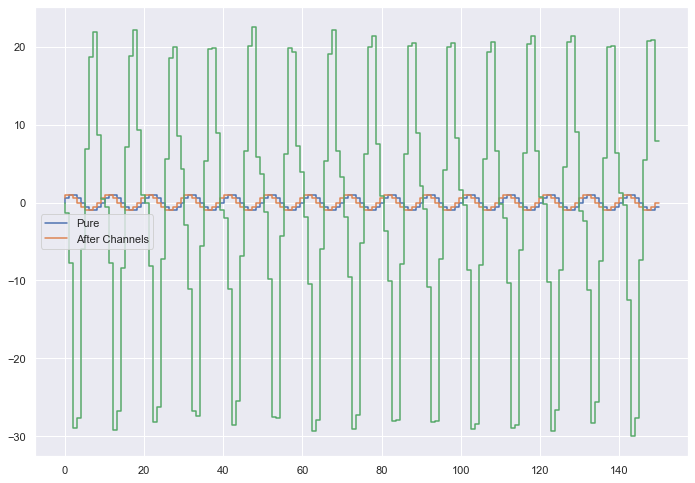

In [10]:
every_input,every_pure_input = update_signal(x=avilable_input,coefficent_matrix=coefficent_matrix,test_size=150)

In [11]:
Memory_Size = 2 - 1
Degree = 5

## RLS Algorithm Call
ext = 0
Degree = Degree +ext
num_vars = Degree*(Memory_Size+1)
lam = 0.98
LS_2 = RLS_Filter(num_vars,lam,1)

pred_e = []
test_size = 150
pred_output = []


for i in range(test_size):
    #Generate Appropriate Regressors
    regressors = np.zeros((Memory_Size+1,Degree ))
    
    for j in range(Memory_Size+1):
        for k in range (Degree):
            #print(every_pure_input[:][j],"\n")
            #print(k)
            regressors[j][k] = every_pure_input[i][j]**(k)
    regressors = regressors.reshape(1,num_vars)
    #print(regressors.T)

    LS_2.add_obs(x=regressors.T,t=every_input[i])
    #Single RLS Data has been evaluated

    pred_e.append(LS_2.get_error())     
    #To observe if the error is in fact decreasing

    get_weigths = LS_2.get_weights()
    #print(get_weigths)

    pred_output.append(regressors*get_weigths)



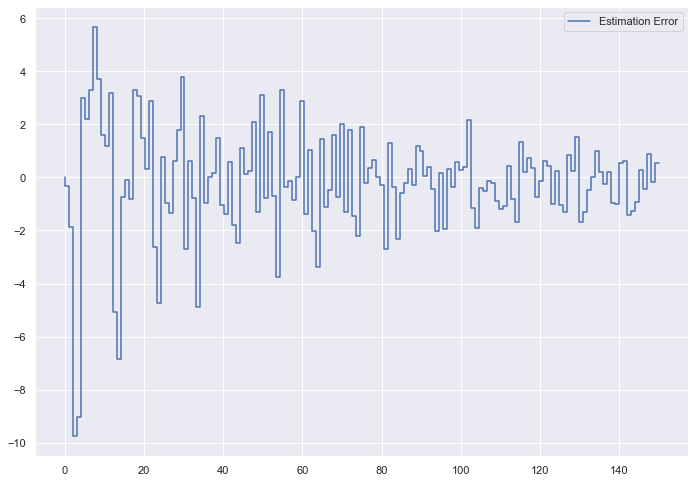

In [12]:
line_refernce = np.linspace(0,test_size,test_size)
plt.step(line_refernce,np.squeeze(pred_e)[0:test_size],    label='Estimation Error')  
#plt.step(line_refernce,np.squeeze(every_pure_input).T[0:test_size][0],label='Pure_Input')      
#plt.step(line_refernce, every_input[0:test_size],label='Curropted Signal') 
#plt.step(line_refernce,every_input[0:test_size],label='Input Signals After The Channels')       
plt.legend()

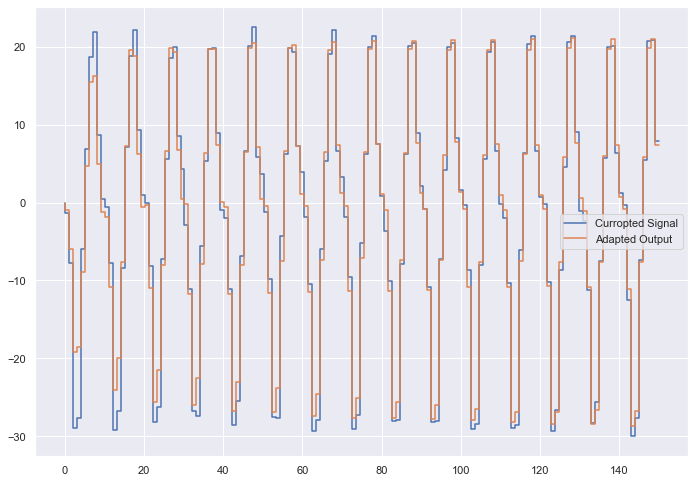

In [13]:
line_refernce = np.linspace(0,test_size,test_size) 
plt.step(line_refernce,every_input[0:test_size],label='Curropted Signal') 
plt.step(line_refernce,np.squeeze(pred_output)[0:test_size],label='Adapted Output')       
plt.legend()